# RTML Midterm 2021

1. In Lab 06, you fine tuned a Mask R-CNN model on the Cityscapes dataset. Download the image at http://www.cs.ait.ac.th/~mdailey/20201112_072342.jpg and run it through
   you model. Provide your source code to load the model, image, get the result, and display the result here. Display the resulting bounding boxes and masks. 

In [1]:
!wget http://www.cs.ait.ac.th/~mdailey/20201112_072342.jpg

--2021-03-12 02:11:18--  http://www.cs.ait.ac.th/~mdailey/20201112_072342.jpg
Connecting to 192.41.170.23:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3320786 (3.2M) [image/jpeg]
Saving to: ‘20201112_072342.jpg’

20201112_072342.jpg 100%[===================>]   3.17M  --.-KB/s    in 0.09s   

2021-03-12 02:11:18 (36.7 MB/s) - ‘20201112_072342.jpg’ saved [3320786/3320786]



In [2]:
# Code to load model, image, and display result here

In [2]:
##Load model
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.datasets import CocoDetection

import utils

# Load a model pre-trained on COCO and put it in inference mode

print('Loading pretrained model...')
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
model.load_state_dict(torch.load('../Lab/Lab06/model/markrcnnCityscape.pth'))

Loading pretrained model...


<All keys matched successfully>

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

<PIL.Image.Image image mode=RGB size=4032x3024 at 0x7FBB213D87F0>
torch.Size([1, 3, 3024, 4032])


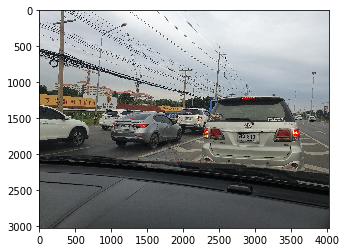

In [7]:
##Load image

import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor()
])

image = Image.open('./20201112_072342.jpg')
image = ImageOps.flip(image)
image = ImageOps.mirror(image)
print(image)
plt.imshow(image)
image = preprocess(image)
image = image.unsqueeze(0).to(device)
print(image.size())

# def collate_fn(batch):
#     return tuple(zip(*batch))

# train_dataloader = torch.utils.data.DataLoader(coco_train_dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)
# val_dataloader = torch.utils.data.DataLoader(coco_val_dataset, batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [8]:
import numpy as np
import cv2
import random

# Array of labels for COCO dataset (91 elements)

coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Random colors to use for labeling objects

COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3)).astype(np.uint8)

# Overlay masks, bounding boxes, and labels on input numpy image

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1
    beta = 0.5 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    # convert from RGB to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(masks)):
        mask = masks[i,:,:]
        red_map = np.zeros_like(mask).astype(np.uint8)
        green_map = np.zeros_like(mask).astype(np.uint8)
        blue_map = np.zeros_like(mask).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[mask > 0.5] = color[0]
        green_map[mask > 0.5] = color[1]
        blue_map[mask > 0.5] = color[2]
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        # apply colored mask to the image
        image = cv2.addWeighted(image, alpha, segmentation_map, beta, gamma)
        # draw the bounding box around each object
        p1 = (int(boxes[i][0]), int(boxes[i][1]))
        p2 = (int(boxes[i][2]), int(boxes[i][3]))
        color = (int(color[0]), int(color[1]), int(color[2]))
        cv2.rectangle(image, p1, p2, color, 2)
        # put the label text above the objects
        p = (int(boxes[i][0]), int(boxes[i][1]-10))
        cv2.putText(image, labels[i], p, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Overlay masks, bounding boxes, and labels of objects with scores greater than
# threshold on one of the images in the input tensor using the predictions output by Mask R-CNN.

def prediction_to_mask_image(images, predictions, img_index, threshold):
    scores = predictions[img_index]['scores']
    boxes_to_use = scores >= threshold
    img = (images[img_index].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    masks = predictions[img_index]['masks'][boxes_to_use, :, :].cpu().detach().squeeze(1).numpy()
    boxes = predictions[img_index]['boxes'][boxes_to_use, :].cpu().detach().numpy()
    labels = predictions[img_index]['labels'][boxes_to_use].cpu().numpy()
    labels = [ coco_names[l] for l in labels ]

    return draw_segmentation_map(img, masks, boxes, labels)

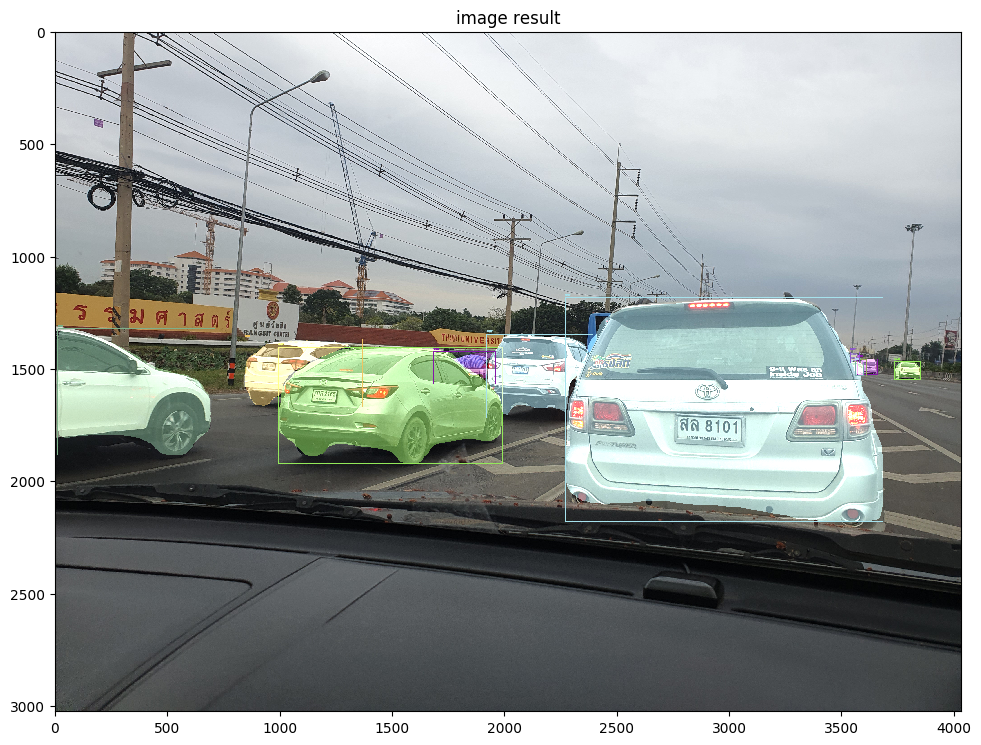

In [9]:
model.eval()
output = model(image)

masked_img = prediction_to_mask_image(image, output, 0, 0.5)
plt.figure(1, figsize=(12, 9), dpi=100)
plt.imshow(masked_img)
plt.title('image result')
plt.show()

2. Write a program that samples 1000 points from a mixture of 4 2D Gaussians with identity covariance centered at (5,5), (10,5), (5,10), and (10,10).
   Provide the code and a plot of the sample.

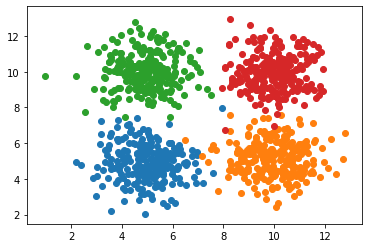

In [48]:
# Code to sample data and display plot here

import torch
import numpy as np
import matplotlib.pyplot as plt

size = 1000
mu = [0, 0]
cov = [[1, 0], [0, 1]]
center = [[5,5], [10,5], [5,10], [10,10]]
alldata = np.zeros((size, len(mu)))

for i in range(len(center)):
    data = np.random.multivariate_normal(mu, cov, size=int(size/len(center)))
    data[:,0] += center[i][0]
    data[:,1] += center[i][1]
    alldata[int(i*size/len(center)):int((i+1)*size/len(center))] = data
    plt.scatter(data[:,0], data[:,1])

3. Write a GAN generator G and discriminator D to model the dataset you generated in Question 2. Train the GAN and display two plots: a fake sample from the generator and the original sample from Question 2.

In [53]:
from torch.utils.data import Dataset, DataLoader

class four_G(Dataset):
    def __init__(self):
        self.alldata = alldata

    def __len__(self):
        return alldata.shape[0]
    
    def __getitem__(self, idx):
        out = self.alldata[idx]
        out = torch.tensor(out)
        return out.float()

In [ ]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import nn, optim

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, loss, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(), '{}/G_epoch'.format(out_dir))
        torch.save(discriminator.state_dict(), '{}/D_epoch'.format(out_dir))
        torch.save(loss, '{}/loss_epoch.loss'.format(out_dir))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [72]:
# Code for the GAN and plots here
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 2
        n_out = 2
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(256, n_out)
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [73]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 2
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(64, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [74]:
def noise(size, dim):
    n = torch.randn(size, dim)
    return n.to(device)

def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    return data.to(device)

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    return data.to(device)

In [75]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake
    
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

discriminator = DiscriminatorNet()
generator = GeneratorNet()

discriminator.to(device)
generator.to(device)

# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Loss function

loss = nn.BCELoss()

# How many epochs to train for

num_epochs = 100000

# Number of steps to apply to the discriminator for each step of the generator (1 in Goodfellow et al.)

d_steps = 1

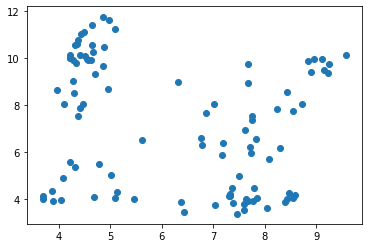

Epoch: [3230/100000], Batch Num: [9/10]
Discriminator Loss: 1.3864, Generator Loss: 0.6882
D(x): 0.5024, D(G(z)): 0.5024


KeyboardInterrupt: 

In [77]:
logger = Logger(model_name='VGAN', data_name='GNoiseDATA')

save_loss = {'d_loss': [],
            'g_loss': []}

dataset = four_G()
data_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
num_batches = len(data_loader)

for epoch in range(num_epochs):
    for n_batch, real_data in enumerate(data_loader):
        # Train discriminator on a real batch and a fake batch
        real_data = real_data.to(device)
        fake_data = generator(noise(real_data.size(0), 2)).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)
        
        # Train generator

        fake_data = generator(noise(real_data.size(0), 2))
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log errors and display progress
        
        save_loss['d_loss'].append(d_error.detach().cpu().numpy())
        save_loss['g_loss'].append(g_error.detach().cpu().numpy())

        logger.log(d_error, g_error, epoch, n_batch, num_batches)
    if (epoch) % 10 == 0:
        display.clear_output(True)
        # Display graph
        plt.scatter(fake_data[:,0].cpu().detach().numpy(), fake_data[:,1].cpu().detach().numpy())
        plt.show()
        # Display status Logs
        logger.display_status(
            epoch, num_epochs, n_batch, num_batches,
            d_error, g_error, d_pred_real, d_pred_fake
        )
        
    # Save model checkpoints
    logger.save_models(generator, discriminator, save_loss, epoch)

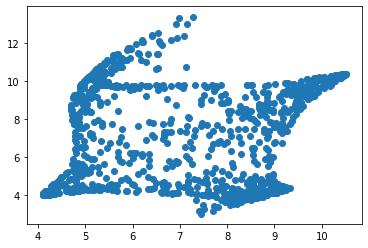

In [78]:
fake_data = generator(noise(1000, 2)).detach()
plt.scatter(fake_data[:,0].cpu().detach().numpy(), fake_data[:,1].cpu().detach().numpy())
plt.show()

4. Suppose you are working on a regression problem for which you have insufficient data and come up with the idea of
   using a GAN to generate new $(\mathbf{x},y)$ pairs. First explain precisely how
   this could be done, then explain why it would be a bad idea.

*Your answer here*

New (x, y) pairs will be generated from model generator. Model generator will learn distribution of input-data and try to re-generate them as fake-data. It try to make fake-data like input-data as much as possible.  Discriminator will judg a generator output is it fake or real. This will help generator know performance of itself.

It is bad idea because 

5. Briefly explain the purpose of weight decay and weight clipping, including how they are similar and how they are different.

*Your answer here*

Both of them use to avoid exploding gradients. Clipping will clip gradients using minimum and maximum value. This cause problem while clipping. If maximum value is large, they will take a long time to reach their limit. Also if minimum is very small, small gradients will be vanishing. Weight decay do something like normallize all gradients by multiply the sum of squares with another smaller number. It adjust gradients updating impact to some smaller range.